### Setup

In [2]:
import datetime
import os


In [3]:
import torch

from torch.utils.data import DataLoader, Subset
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
from torchvision.utils import make_grid



/home/ciafa/mnt_point_3/dasilva/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

In [4]:
# MODEL variables
BATCH_SIZE = 4

# INPUT variables
data_dir = os.path.join("data", "Alzheimer_s Dataset", "train/")
SRC_IMG_HEIGHT, SRC_IMG_WIDTH = 208, 176

# SYNTH variables
N_TO_GENERATE = 50
SYNTHETIC_BASE_DIR = 'data/synth'
CLASSES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
CLASS_TO_GENERATE = CLASSES[0]

In [5]:
RESIZE = (SRC_IMG_HEIGHT, SRC_IMG_WIDTH)
RESIZE = None
#RESIZE = 256, 256

In [6]:
rm_transforms = []
#rm_transforms += [transforms.Grayscale()]

if RESIZE is not None:
    rm_transforms += [transforms.Resize(RESIZE)]
rm_transforms += [transforms.ToTensor()]
rm_transforms += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
print(rm_transforms)

rm_dataset = datasets.ImageFolder(root=data_dir,
                                 transform=transforms.Compose(rm_transforms))

[ToTensor(), Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]


In [7]:
list(rm_dataset.class_to_idx.keys())

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [8]:
indices = [idx for idx, target in enumerate(rm_dataset.targets) if target == rm_dataset.class_to_idx[CLASS_TO_GENERATE]]
print(f'{len(indices)} samples from class {CLASS_TO_GENERATE}')

1792 samples from class VeryMildDemented


In [9]:
dataloader = DataLoader(Subset(rm_dataset, indices),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        drop_last=True)

### GAN implementation

In [10]:
import numpy as np
import math
from tqdm import tqdm, trange

from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import os.path

if RESIZE is not None:
    img_shape = 3, RESIZE[0], RESIZE[1]
else:
    img_shape = 3, SRC_IMG_HEIGHT, SRC_IMG_WIDTH
print('img_shape:', img_shape)

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(self.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


class GAN:
  def __init__(self, b1=0.5, b2=0.999, lr=0.0002, latent_dim=100, n_epochs=100):
    
    self.b1 = b1
    self.b2 = b2
    self.lr = lr
    self.n_epochs = n_epochs
    self.latent_dim = latent_dim
    self.cuda = True if torch.cuda.is_available() else False

    self.adversarial_loss = torch.nn.BCELoss()
    self.generator = Generator(latent_dim)
    self.discriminator = Discriminator()


    if self.cuda:
        self.generator.cuda()
        self.discriminator.cuda()
        self.adversarial_loss.cuda()

  def fit(self, dataloader):
    optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
    optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))

    Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor
    logger = trange(self.n_epochs, desc=f"Epoch: 0, G_Loss: 0, D_Loss: 0")
    
    for epoch in logger:
        for i, (imgs, _) in enumerate(dataloader):
            #print('imgs.size(0)', imgs.shape)
            valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
            real_imgs = Variable(imgs.type(Tensor))

            optimizer_G.zero_grad()

            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], self.latent_dim))))

            gen_imgs = self.generator(z)

            g_loss = self.adversarial_loss(self.discriminator(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()

            real_loss = self.adversarial_loss(self.discriminator(real_imgs), valid)
            fake_loss = self.adversarial_loss(self.discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()
            
  def generate(self, n_samples):
    Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor
    z = Variable(Tensor(np.random.normal(0, 1, (n_samples, self.latent_dim))))
    return self.generator(z)

  def fn_gen(self, base_dir: str, prefix: str, fn: str):
        return os.path.join(base_dir, f'{prefix}_{fn}')

  def store(self, base_dir: str = '.',
           prefix: str = ''):
    generator_path = self.fn_gen(base_dir, prefix, 'generator.pt')
    discriminator_path = self.fn_gen(base_dir, prefix, 'discriminator.pt')
    torch.save(self.generator.state_dict(), generator_path)
    torch.save(self.discriminator.state_dict(), discriminator_path)
    
  def load(self, base_dir: str = '.',
           prefix: str = '', print_loaded_model: bool = False):
    generator_path = self.fn_gen(base_dir, prefix, 'generator.pt')
    self.generator.load_state_dict(torch.load(generator_path))
    if print_loaded_model:
        print(self.generator.eval())
    
    discriminator_path = self.fn_gen(base_dir, prefix, 'discriminator.pt')
    self.discriminator.load_state_dict(torch.load(discriminator_path))
    if print_loaded_model:
        print(self.discriminator.eval())
    
    
# generate samples for indicated class
def create_save_samples(model: GAN, base_dir, n_imgs: int = 50, img_batch_size: int = 5):
    

    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
        
    real_n_imgs = n_imgs - (n_imgs % img_batch_size)
    print(f'generating {real_n_imgs} images')

    for i in tqdm(range(0, real_n_imgs, img_batch_size), ncols=100):
        
        fn_datetime_prefix = datetime.datetime.now().strftime(f'%Y_%m_%d_%H_%M_%S')

        with torch.no_grad():
            imgs = model.generate(img_batch_size)

        for j, im_tensor in enumerate(imgs):
            im_fn = f'{fn_datetime_prefix}__{i}_{j}.jpg'
            im_path = os.path.join(base_dir, im_fn)
            #print(i, im_path)
            save_image(im_tensor, im_path)

img_shape: (3, 208, 176)


##### Learn

In [ ]:
gan = GAN(n_epochs=10, latent_dim=100)

In [ ]:
gan.fit(dataloader)

##### Generate/Plot

In [ ]:
with torch.no_grad():
  grid_img = make_grid(gan.generate(5), nrow=5)
  plt.imshow(grid_img.permute(1,2,0).cpu().detach().numpy())


In [ ]:
gan2 = GAN(n_epochs=200)
gan2.fit(dataloader)

In [ ]:
with torch.no_grad():
  grid_img = make_grid(gan2.generate(5), nrow=5)
  plt.imshow(grid_img.permute(1,2,0).cpu().detach().numpy())


In [ ]:
gan2.store(prefix=CLASS_TO_GENERATE)

# Run from stored model

In [20]:
# MODEL variables
BATCH_SIZE = 4

# INPUT variables
data_dir = os.path.join("data", "Alzheimer_s Dataset", "train")
SRC_IMG_HEIGHT, SRC_IMG_WIDTH = 208, 176

# SYNTH variables
N_TO_GENERATE = 1000
SYNTHETIC_BASE_DIR = os.path.join('data', 'synth', 'test')


## test stored model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


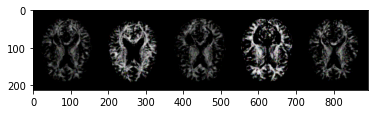

In [22]:
CLASS_TO_GENERATE = CLASSES[1]
ganL = GAN()
ganL.load(prefix=class_to_generate)
with torch.no_grad():
    grid_img = make_grid(ganL.generate(5), nrow=5)
    plt.imshow(grid_img.permute(1,2,0).cpu().detach().numpy())


In [18]:
for class_to_generate in CLASSES:
    print(class_to_generate)
    ganL = GAN()
    ganL.load(prefix=class_to_generate)
    create_save_samples(ganL, os.path.join(SYNTHETIC_BASE_DIR, class_to_generate), n_imgs=N_TO_GENERATE)

MildDemented
generating 1000 images


100%|████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 114.54it/s]


ModerateDemented
generating 1000 images


100%|████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 112.25it/s]


NonDemented
generating 1000 images


100%|████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 115.06it/s]


VeryMildDemented
generating 1000 images


100%|████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 113.07it/s]
